In [74]:
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data/cleaned/ga_hta_socioeconomic_2024_clean.csv')
df['language'] = LabelEncoder().fit_transform(df['language'])
df = df.dropna().set_index('postcode')

# Split by canton (80% cantons to train, rest test)
canton_list = df['canton'].unique()
train_cantons = np.random.choice(canton_list, int(0.8 * len(canton_list)), replace=False)
test_cantons = [c for c in canton_list if c not in train_cantons]

# Split by canton (80% cantons to train, rest test)
train_cantons = ['SG', 'BL', 'VS', 'OW', 'NE', 'GE', 'TG', 'BE', 'SH', 'LU', 'AG',
       'UR', 'GL', 'ZG', 'SO', 'AI', 'GR', 'TI', 'BS', 'SZ']
test_cantons = ['VD', 'FR', 'JU', 'NW', 'ZH', 'AR']

train_df = df[df['canton'].isin(train_cantons)]
test_df = df[df['canton'].isin(test_cantons)]

X_cols = [
    'num_stops', 'stop_density', 'avg_daily_frequency', 'max_stop_frequency',
    'population', 'male_population', 'swiss_citizen', 'married', 'age_20_64',
    'gdp_per_capita', 'eco_activity_rate', 'unemploy_rate',
    'total_residential_housing', 'pure_residential_single', 'pure_residential_multiple',
    'language'
]

X_train, y_train = train_df[X_cols], train_df[['GA_log', 'HTA_log']]
X_test, y_test = test_df[X_cols], test_df[['GA_log', 'HTA_log']]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [75]:
y_test

,GA_log,HTA_log
postcode,,
1000,4.553877,7.422971
1003,6.565265,8.302514
1004,7.403670,9.464362
1005,6.689599,8.759041
1006,7.173192,9.001716
...,...,...
9107,4.532599,6.771936
9410,5.068904,7.392032
9411,3.044522,5.342334


In [76]:
def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

In [77]:
# linear regression
lrg = LinearRegression()
lrg.fit(X_train_scaled, y_train_scaled)
evaluate(lrg, X_test_scaled, y_test_scaled, "LinearRegressor")

LinearRegressor R²: 0.7465, MAE: 0.43, RMSE: 0.56


In [78]:
# ridge regression
rrg = Ridge(alpha=1.0)
rrg.fit(X_train_scaled, y_train_scaled)
evaluate(rrg, X_test_scaled, y_test_scaled, "RidgeRegressor")

RidgeRegressor R²: 0.7635, MAE: 0.42, RMSE: 0.55


In [81]:
# random forest
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, random_state=88))
rf.fit(X_train_scaled, y_train_scaled)
evaluate(rf, X_test_scaled, y_test_scaled, "RandomForest")

RandomForest R²: 0.9000, MAE: 0.27, RMSE: 0.35


In [82]:
# xgboost
xgb_model = MultiOutputRegressor(xgb.XGBRegressor(random_state=88))
xgb_model.fit(X_train_scaled, y_train_scaled)
evaluate(xgb_model, X_test_scaled, y_test_scaled, "XGBoost")

XGBoost R²: 0.8959, MAE: 0.28, RMSE: 0.36


In [86]:
# lgbm
lgbm_model = MultiOutputRegressor(lgb.LGBMRegressor(objective='regression_l2', random_state=88))
lgbm_model.fit(X_train_scaled, y_train_scaled)
evaluate(lgbm_model, X_test_scaled, y_test_scaled, "LightGBM")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 1433, number of used features: 16
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 1433, number of used features: 16
[LightGBM] [Info] Start training from score -0.000000
LightGBM R²: 0.9085, MAE: 0.26, RMSE: 0.33


In [101]:
# catboost
cat_model = MultiOutputRegressor(CatBoostRegressor(verbose=0, random_state=88))
cat_model.fit(X_train_scaled, y_train_scaled)
evaluate(cat_model, X_test_scaled, y_test_scaled, "CatBoost")

CatBoost R²: 0.9164, MAE: 0.25, RMSE: 0.32


In [92]:
# mlp
mlp = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(8,8), activation='relu', max_iter=1000, random_state=88))
mlp.fit(X_train_scaled, y_train_scaled)
evaluate(mlp, X_test_scaled, y_test_scaled, "MLPRegressor")

MLPRegressor R²: 0.8970, MAE: 0.28, RMSE: 0.35


In [102]:
# SHAP

import shap

explainer = shap.Explainer(cat_model.predict, X_train_scaled)
shap_values = explainer(X_train_scaled)


PermutationExplainer explainer: 1434it [08:10,  2.88it/s]                          


In [106]:
shap_values.feature_names=X_cols

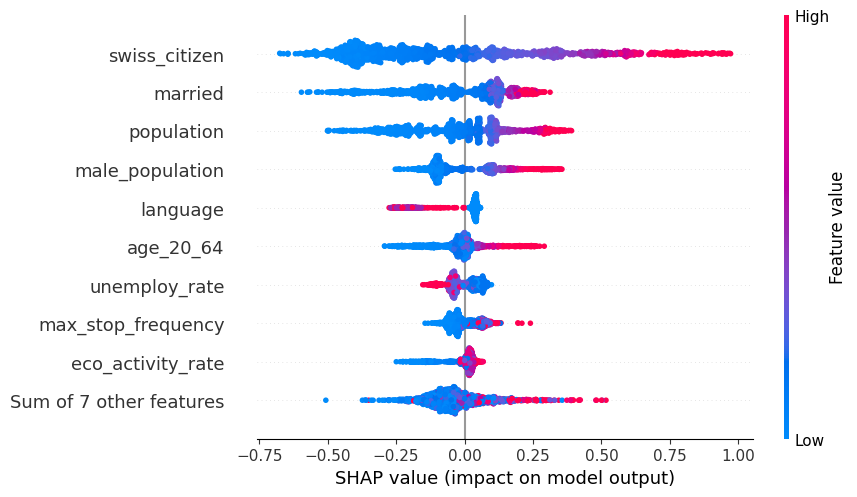

In [107]:
shap.plots.beeswarm(shap_values[:,:,1])

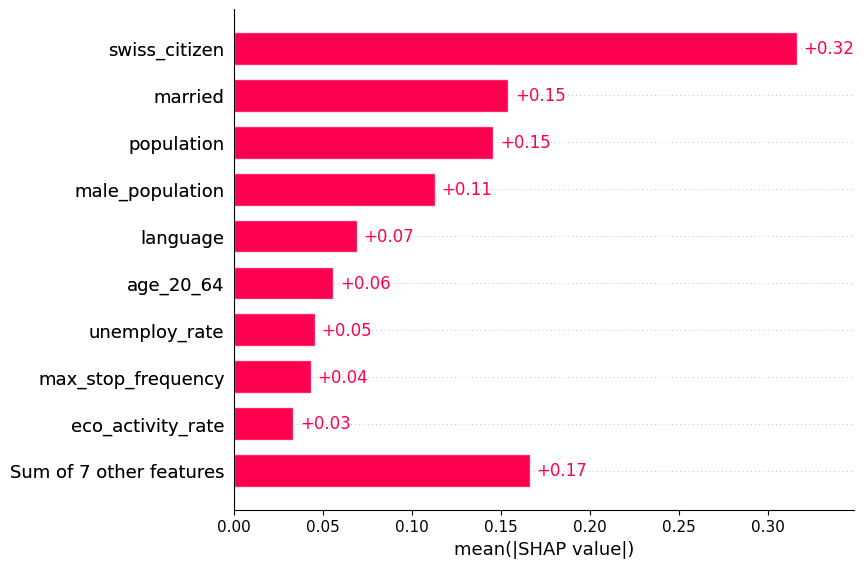

In [108]:
shap.plots.bar(shap_values[:,:,1])